In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (10,6)

In [4]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

In [5]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [6]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [7]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd


,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [8]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < 6.34725)]

outlier


primeiro_quartil: valor    6.9
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.2685
Name: 0.75, dtype: float64
fig: valor    0.3685
dtype: float64
Inferior: valor    6.34725
dtype: float64
Superior: valor    7.82125
dtype: float64


C:\Users\Anderson\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1987-01-31,6.2


In [9]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] == 6.20] = 7.08

outlier = trainingd[(trainingd.valor < 6.34725)]

outlier

,valor
data_coleta,


In [10]:
trainingd

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [96]:
#Dados completo.
data = trainingd.iloc[:,:].values
#treino (70%)
train = trainingd.iloc[0:174,:].values  
#teste (30%)
test = trainingd.iloc[174:,:].values 

testd = test

print('Completo:',len(data))
print('treino:',len(train))
print('teste:',len(test))
#print(testd)
data.shape

Completo: 248
treino: 174
teste: 74


(248, 1)

In [97]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
train = sc.fit_transform(train)
test = sc.fit_transform(test)


In [98]:
#Prepara o conjunto de dados em X e y, considerando a janela de visualização (lags).
def prepara_dados(dados,lags):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i, 0])
        y.append(dados[i, 0])
    return np.array(X), np.array(y)

#Calcula o MAPE
#Define função para calcular o MAPE
#def mape(y_pred,y_true):
 #   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

def rquadrado(y_pred,y_true):
    #Soma Total dos Quadrados (STQ): mostra a variação de y em torno da própria média. 
    #É o somatório das diferenças entre o valor alvo real e sua média elevado ao quadrado.
    y_traco = np.mean(y_true)
    
    print('media y_true:', y_traco)
        
    stq = 0
    
    for s in y_true:
        a = s - y_traco
        st = a * a
        stq = stq + st
    
    print('Soma Total dos Quadrados (STQ):', stq[0])
    
    #Soma dos Quadrados dos Resíduos (SQU): variação de Y que não é explicada pelo modelo elaborado. 
    #É o somatório das diferenças entre o valor predito e o valor real elevados ao quadrado.
    squ = 0
    
    y_traco = np.mean(y_pred)
    print('media y_pred:', y_traco)
    
    for n in range(len(y_true)):
        a = y_true[n] - y_pred[n]
        st = a * a
        squ = squ + st
        
    print('Soma dos Quadrados dos Resíduos (SQU):',squ[0])
    
    sqr = stq[0] - squ[0]
    sqr = sqr/stq[0]
    
    return sqr


0.5041337228217908


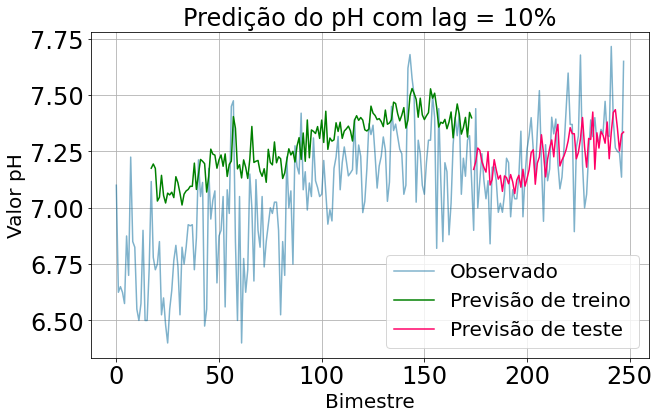

In [99]:
lags = 17 # Equivalente à 10% dos dados de treino.
#Prepara os dados de treinamento
train_X, train_y = prepara_dados(train, lags)
    
#Prepara os dados de teste
entradas = trainingd[len(trainingd) - len(test) - lags:].values
entradas = entradas.reshape(-1, 1)
entradas = sc.fit_transform(entradas)

test_X = []
for i in range(lags, lags+len(test)):
    test_X.append(entradas[i-lags:i, 0])
test_X = np.array(test_X)
    
#Cria o modelo
model = LinearRegression(normalize=True)

#Treina o modelo
model.fit(train_X,train_y)
score = model.score(train_X,train_y)
print(score)

#Dados de teste
previsoes = model.predict(test_X)
previsoes = previsoes.reshape(-1, 1)
previsoes = sc.inverse_transform(previsoes)

#Dados de treino
previsoes_treino = model.predict(train_X)
previsoes_treino = previsoes_treino.reshape(-1, 1)
previsoes_treino = sc.inverse_transform(previsoes_treino)

#Preparação para plotagem
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(previsoes_treino) + lags, :] = previsoes_treino
train_predict_plot.shape
    
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+lags:len(data), :] = previsoes

#Plotagem do gráfico
plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(train_predict_plot, color = 'green', label = 'Previsão de treino')
plt.plot(test_predict_plot, color = '#ff0066', label = 'Previsão de teste')
plt.title('Predição do pH com lag = 10%')
plt.xlabel('Bimestre')
plt.ylabel('Valor pH')
plt.legend()
plt.grid()
plt.show()
    
#Calculo do erro da previsão
#mape(previsoes.mean(),test.mean())
test = sc.inverse_transform(test)
treino = sc.inverse_transform(train[lags: len(previsoes_treino) + lags, :])




In [101]:
print('Resultados com lag', lags)
print('\n')
print('MAPE TREINO:',round(mape(previsoes_treino,treino)[0],2),'%')
print('RMSE TREINO:',round(rmse(previsoes_treino,treino),2))
print('R TREINO:',round(r2(previsoes_treino,treino),2))
print('\n')
print('\n')
print('R na mao:',round(rquadrado(previsoes_treino,treino),2))
print('\n')
print('MAPE TESTE:',round(mape(previsoes,test)[0],2),'%')
print('RMSE TESTE:',round(rmse(previsoes,test),2))
print('R TESTE:',round(r2(previsoes,test),2))
print('\n')

print('R mao:',round(rquadrado(previsoes,test),2))

Resultados com lag 17


MAPE TREINO: 2.18 %
RMSE TREINO: 0.13
R TREINO: 0.5




media y_true: 7.284592910771552
Soma Total dos Quadrados (STQ): 5.082604122223282
media y_pred: 7.284592910771552
Soma dos Quadrados dos Resíduos (SQU): 2.520291984457481
R na mao: 0.5


MAPE TESTE: 1.33 %
RMSE TESTE: 0.16
R TESTE: 0.21


media y_true: 7.226925675675674
Soma Total dos Quadrados (STQ): 2.499982841216216
media y_pred: 7.234304255789539
Soma dos Quadrados dos Resíduos (SQU): 1.9739095305138257
R mao: 0.21


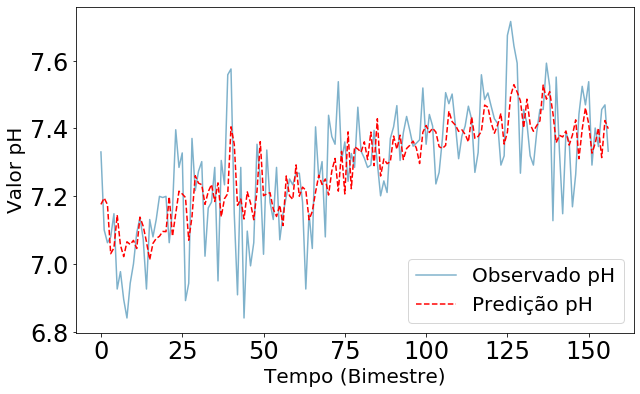

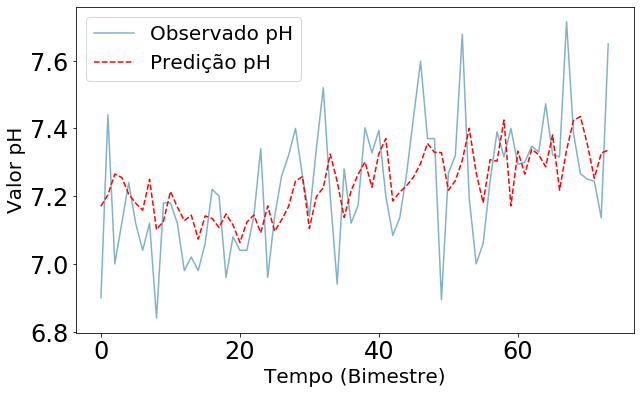

"\nprint(len(observado_treino_x))\nprint(len(observado_treino))\nprint(len(previsoes_treino))\n\n#Plotagem do gráfico\n#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')\nplt.scatter(observado_treino_x,observado_treino, color = 'red', label = 'Observado pH')\nplt.scatter(observado_treino_x,previsoes_treino, color = '#006699', label = 'Predição pH')\nplt.title('Predição do pH com lag = 10%')\nplt.xlabel('Observado pH')\nplt.ylabel('Predição pH')\n#plt.legend()\n#plt.grid()\nplt.show()\n"

In [187]:
train_y = train_y.reshape(-1, 1)
observado_treino = sc.inverse_transform(train_y)

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(observado_treino, color = '#006699', alpha=0.5, label = 'Observado pH')
plt.plot(previsoes_treino, color = 'red',linestyle = '--', label = 'Predição pH')
#plt.title('Predição do pH com lag = 10%')
plt.xlabel('Tempo (Bimestre)')
plt.ylabel('Valor pH')
plt.legend()
#plt.grid()
plt.show()

observado_test = testd

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(observado_test, color = '#006699', alpha=0.5, label = 'Observado pH')
plt.plot(previsoes, color = 'red',linestyle = '--', label = 'Predição pH')
#plt.title('Predição do pH com lag = 10%')
plt.xlabel('Tempo (Bimestre)')
plt.ylabel('Valor pH')
plt.legend()
#plt.grid()
plt.show()

'''
print(len(observado_treino_x))
print(len(observado_treino))
print(len(previsoes_treino))

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.scatter(observado_treino_x,observado_treino, color = 'red', label = 'Observado pH')
plt.scatter(observado_treino_x,previsoes_treino, color = '#006699', label = 'Predição pH')
plt.title('Predição do pH com lag = 10%')
plt.xlabel('Observado pH')
plt.ylabel('Predição pH')
#plt.legend()
#plt.grid()
plt.show()
'''

In [148]:
a = previsoes[62,:][0]
round(a,2)




7.34

In [159]:
trainingd.loc[trainingd[trainingd.index > '2017-11-01'].index & trainingd[trainingd.index < '2018-06-30'].index]

,valor
data_coleta,
2017-11-30,7.322
2018-01-31,7.316
2018-03-31,7.716
2018-05-31,7.386


In [160]:
trainingd.loc[trainingd[trainingd.index > '2018-07-01'].index & trainingd[trainingd.index < '2018-08-31'].index]

,valor
data_coleta,
2018-07-31,7.266


In [188]:
novo = trainingd.reset_index()

In [213]:
X = novo['data_coleta'].values
y = novo['valor'].values

#len(X[174:248])

p = []

for i in range(len(previsoes)):
    p.append(round(previsoes[i][0],2))

    

obj = {'data': X[174:248], 'prev': p}

dfnovo = pd.DataFrame(data=obj)
dfnovo



,data,prev
0,2007-01-31,7.17
1,2007-03-31,7.20
2,2007-05-31,7.27
3,2007-07-31,7.25
4,2007-09-30,7.21
...,...,...
69,2018-07-31,7.44
70,2018-09-30,7.35
71,2018-11-30,7.25
72,2019-01-31,7.33


In [220]:
#dfnovo.loc[dfnovo.data > '2017-11-01' & dfnovo.data < '2018-08-31']

dfnovo.loc[dfnovo.data > '2017-11-01']

,data,prev
65,2017-11-30,7.38
66,2018-01-31,7.22
67,2018-03-31,7.34
68,2018-05-31,7.42
69,2018-07-31,7.44
70,2018-09-30,7.35
71,2018-11-30,7.25
72,2019-01-31,7.33
73,2019-03-31,7.34


In [233]:
a = [7.38]
b = [7.17]

a = np.array([7.38])
b = np.array([7.17])

def mapes(y_pred,y_true):
    mape = (abs((y_true - y_pred))/y_true)
    return mape

print('Chuvoso')
print('MAPE TESTE:',round(mapes(7.38,7.17),2),'%')
print('RMSE TESTE:',round(rmse(a,b),2))
print('R TESTE:',round(r2(a,b),2))

a = [7.44]
b = [7.36]

a = np.array([7.44])
b = np.array([7.36])

def mapes(y_pred,y_true):
    mape = (abs((y_true - y_pred))/y_true)
    return mape

print('Seco')
print('MAPE TESTE:',round(mapes(7.44,7.36),2),'%')
print('RMSE TESTE:',round(rmse(a,b),2))
print('R TESTE:',round(r2(a,b),2))

Chuvoso
MAPE TESTE: 0.03 %
RMSE TESTE: 0.21
R TESTE: nan
Seco
MAPE TESTE: 0.01 %
RMSE TESTE: 0.08
R TESTE: nan


C:\Users\Anderson\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Anderson\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
